In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from scipy.stats import spearmanr
import matplotlib.pyplot as plt


In [ ]:
import os 
from dotenv import load_dotenv
from pathlib import Path
load_dotenv()
DIR = Path(os.getenv("CSV_OUTPUT_PATH"))
CSV_FILE = os.getenv("CLEANED_ARTICLES_FILENAME")
file = DIR / CSV_FILE

MODEL_OUTPUT_PATH = Path(os.getenv("MODEL_OUTPUT_PATH"))
NP_OUTPUT_PATH = Path(os.getenv("NP_OUTPUT_PATH"))
MODEL_FILE = os.getenv("MODEL_FILENAME")
EMBEDDED_ARTICLES_FILENAME = os.getenv("EMBEDDED_ARTICLES_FILENAME")

In [3]:
def compute_similarity(model, df):
    model_scores, human_scores = [], []
    for _, row in df.iterrows():
        w1, w2, human_score = row["word1"], row["word2"], row["human_score"]
        if w1 in model.wv and w2 in model.wv:
            model_scores.append(model.wv.similarity(w1, w2))
            human_scores.append(human_score)
    return spearmanr(human_scores, model_scores).correlation if model_scores else None

In [ ]:
data = pd.read_csv(file)

# dedupe the data based on title 
print(f"count before deupe: {len(data)}")
data = data.drop_duplicates(subset="article_title")
print(f"count after deupe: {len(data)}")

count before deupe: 363820
count after deupe: 259141


In [7]:
token_lists = []
vocab = set()
# loop through df_cleaned['tokens'] and append each list of tokens to token_list
for token_list in data['tokens']:
    convert_to_list = eval(token_list)
    vocab.update(convert_to_list)
    token_lists.append(convert_to_list)

In [13]:
# load similarity data
df_sim = pd.read_csv("https://raw.githubusercontent.com/kliegr/word_similarity_relatedness_datasets/refs/heads/master/win353.csv", names=["word1", "word2", "human_score"])
df_sim.head()

,word1,word2,human_score
0,Word 1,Word 2,Human (Mean)
1,admission,ticket,5.846
2,alcohol,chemistry,1.154
3,aluminum,metal,6.286
4,announcement,effort,2.000


# TUNE VECTOR_SIZES

In [ ]:
models = {}

In [30]:
vector_sizes = range(300,701,100)

for vec_size in vector_sizes:
    if vec_size in models.keys():
        continue
    print(f"Training Word2Vec with vector_size={vec_size}")
    model = Word2Vec(sentences=token_lists, vector_size=vec_size, window=5, min_count=2, sg=1, workers=24)
    models[vec_size] = model

Training Word2Vec with vector_size=700


In [32]:
results = {}

for vec_size, model in models.items():
    similarity_score = compute_similarity(model, df_sim)
    results[vec_size] = similarity_score
    print(f"Vector Size {vec_size}: Spearman correlation = {similarity_score:.4f}")


Vector Size 300: Spearman correlation = 0.2505
Vector Size 400: Spearman correlation = 0.2555
Vector Size 500: Spearman correlation = 0.2407
Vector Size 600: Spearman correlation = 0.2441
Vector Size 700: Spearman correlation = 0.2436


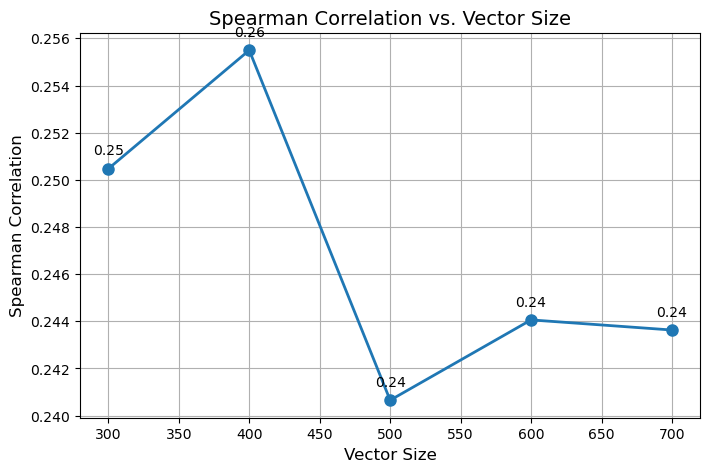

In [33]:
# Extract vector sizes and corresponding Spearman correlation scores
vector_sizes = list(results.keys())
correlation_scores = list(results.values())

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(vector_sizes, correlation_scores, marker='o', linestyle='-', linewidth=2, markersize=8)

# Annotate points
for i, txt in enumerate(correlation_scores):
    plt.annotate(f"{txt:.2f}", (vector_sizes[i], correlation_scores[i]), textcoords="offset points", xytext=(0, 10), ha='center')

# Labels and title
plt.xlabel("Vector Size", fontsize=12)
plt.ylabel("Spearman Correlation", fontsize=12)
plt.title("Spearman Correlation vs. Vector Size", fontsize=14)
plt.grid(True)

# Show plot
plt.show()


In [29]:
best_vec_size = max(results, key=results.get)
print(f"Best vector size: {best_vec_size} with Spearman correlation {results[best_vec_size]:.4f}")

Best vector size: 400 with Spearman correlation 0.2555


# TUNE WINDOW

In [34]:
models_window = {}

In [46]:
window_ranges = range(2,10,2)
vector_size = best_vec_size

for window in window_ranges:
    if window in models_window.keys():
        continue
    print(f"Training Word2Vec with window={window}")
    model = Word2Vec(sentences=token_lists, vector_size=vector_size, window=window, min_count=2, sg=1, workers=24)
    models_window[window] = model

Training Word2Vec with window=2
Training Word2Vec with window=4
Training Word2Vec with window=6
Training Word2Vec with window=8


In [52]:
results_window = {}

for window, model in models_window.items():
    similarity_score = compute_similarity(model, df_sim)
    results_window[window] = similarity_score
    print(f"window Size {window}: Spearman correlation = {similarity_score:.4f}")


window Size 2: Spearman correlation = 0.2268
window Size 4: Spearman correlation = 0.2568
window Size 6: Spearman correlation = 0.2470
window Size 8: Spearman correlation = 0.2491


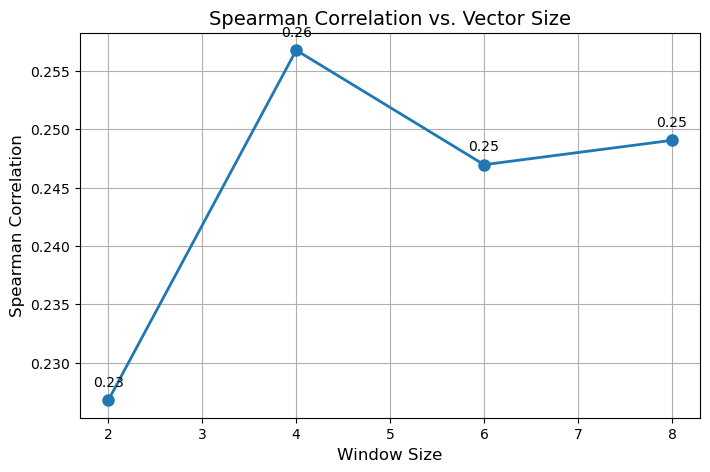

In [53]:
# Extract vector sizes and corresponding Spearman correlation scores
window_sizes = list(results_window.keys())
correlation_scores = list(results_window.values())

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(window_sizes, correlation_scores, marker='o', linestyle='-', linewidth=2, markersize=8)

# Annotate points
for i, txt in enumerate(correlation_scores):
    plt.annotate(f"{txt:.2f}", (window_sizes[i], correlation_scores[i]), textcoords="offset points", xytext=(0, 10), ha='center')

# Labels and title
plt.xlabel("Window Size", fontsize=12)
plt.ylabel("Spearman Correlation", fontsize=12)
plt.title("Spearman Correlation vs. Vector Size", fontsize=14)
plt.grid(True)

# Show plot
plt.show()

In [56]:
best_window_size = max(results_window, key=results_window.get)
print(f"Best window size: {best_window_size} with Spearman correlation {results_window[best_window_size]:.4f}")

Best window size: 4 with Spearman correlation 0.2568


In [ ]:
best_model = models_window[best_window_size]
best_model.save(f"{MODEL_OUTPUT_PATH}/{MODEL_FILENAME}")

In [ ]:
def save_article_vectors(tokens_list, model, save_path="article_vectors.npy"):
    # Function to compute the vector representation of an article
    def get_article_vector(tokens, model):
        vectors = [model.wv[word] for word in tokens if word in model.wv]
        return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

    # Convert all articles into vectors
    article_vectors = np.array([get_article_vector(tokens, model) for tokens in tokens_list])

    # Save the article vectors
    np.save(save_path, article_vectors)

    print(f"Saved {article_vectors.shape[0]} article vectors to {save_path}")
    return article_vectors


In [ ]:
article_vectors = save_article_vectors(token_lists, best_model, save_path=f"{NP_OUTPUT_PATH}/{EMBEDDED_ARTICLES_FILENAME}")

Saved 259141 article vectors to scratch/Word2Vec//np/word2vec_financial_news_400_4.npy
